In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.mlab import griddata

### Fixed Parameters

In [3]:
Data=pd.read_csv("cases_durations.csv",sep = ',', header = 0)
Data

,Unnamed: 0,Start,End,where,country,Recovered,Deaths,Total Cases,Lat,Long,duration,Sm,Sy,Em,Ey,Duration
0,0,09/1998,04/1999,Perak,M,160,105,265,4.592113,101.090109,NaN,9,1998,4,1999,212
1,1,09/1998,04/1999,selangor,M,160,105,265,3.073838,101.518347,NaN,9,1998,4,1999,212
2,2,09/1998,04/1999,Negeri Sembilan,M,160,105,265,2.725806,101.942378,NaN,9,1998,4,1999,212
3,3,03/1999,04/1999,Singapore,S,10,1,11,1.352083,103.819836,NaN,3,1999,4,1999,31
4,4,02/2001,03/2001,Siliguri,I,21,45,66,26.727101,88.395286,NaN,2,2001,3,2001,28
5,5,04/2001,05/2001,Meherpur,B,4,9,13,23.805199,88.672358,NaN,4,2001,5,2001,30
6,6,01/2003,02/2003,Naogaon,B,4,8,12,24.913160,88.753095,NaN,1,2003,2,2003,31
7,7,01/2004,02/2004,Goalando,B,7,22,29,23.684042,89.699655,NaN,1,2004,2,2004,31
8,8,04/2004,05/2004,Faridpur,B,9,27,36,23.542392,89.630892,NaN,4,2004,5,2004,30
9,9,01/2005,03/2005,Tangail,B,1,11,12,24.251345,89.916710,NaN,1,2005,3,2005,59


In [7]:
β = 0.005
μ1 = 1/21 #14 days infectious
μ2 = 1/5 #5 days (14 - 9 days)
σ =1/5 #5 days exposed
ω=1/9 # 9 days until emitted to hospital
ϵ = 0.0001
α = 1/2
pp = 0.7
capT = 10000
γ = 1/(80*365)
Input_H = [1500,1,0,0,0]
Nn = sum(Input_H)

# SEIHR with fixed parameters

In [5]:
def gillespieSEIHR(initial, beta, mu1,mu2, sigma, omega,epsilon,alpha, mort, gam,  max_time):
    event_time = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    event_time.append(0)
    times = 0
    ind = 0
    cuminf = []
    cuminf.append(0)
    events = []
    while times <max_time and (pop[ind][1]+pop[ind][2]+pop[ind][3]>0):
        state = np.zeros(shape= (5,12))
        
        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################
        
        
        R_se = beta*(pop[ind][0])*(pop[ind][2] + alpha*pop[ind][3])/N + epsilon*pop[ind][0] 
        state[:,0] = [-1, 1, 0, 0,0]
        
        R_ei = sigma*pop[ind][1]
        state[:,1] = [0, -1, 1, 0,0]
        
        R_ih = omega*pop[ind][2]
        state[:,2] = [0, 0, -1, 1, 0]
        
        R_ir = mort*mu1*pop[ind][2]
        state[:,3] = [0,0,-1,0,1]
        
        R_hr = mort*mu2*pop[ind][3]
        state[:,4] = [0,0,0,-1,1]
#         print('R_ir',  R_ir)
        R_is = (1-mort)*mu1*pop[ind][2]
        state[:,5] = [1,0,-1,0,0]
#         print('R_is', R_is)
        R_hs = (1-mort)*mu2*pop[ind][3]
        state[:,6] = [1,0,0,-1,0]
        
        ########################### natural deaths + births #################################
# #         R_sb = 0.00001
#         R_sb = gam*1500
# #         print('R_sb', R_sb)
#         state[:,7] = [1,0,0,0,0]

#         R_sd = -gam*pop[ind][0]
#         state[:,8] = [-1,0,0,0,0]
# #         print('R_sd', R_sd)
#         R_ed = -gam*pop[ind][1]
#         state[:,9] = [0,-1,0,0,0]
        
#         R_id = -gam*pop[ind][2]
#         state[:,10] = [0,0,-1,0,0]   
        
#         R_hd = -gam*pop[ind][3]
#         state[:,11] = [0,0,0,-1,0]
        
        #####################################################################################
        
#         rate = [R_se, R_ei, R_ih, R_ir, R_hr, R_is, R_hs, R_sb, R_sd, R_ed, R_id, R_hd]
        rate = [R_se, R_ei, R_ih, R_ir, R_hr, R_is, R_hs]

        Rtotal = sum(rate)
        delta_t= -np.log(np.random.uniform(0,1))/Rtotal
#         print(delta_t, Rtotal, np.log(np.random.uniform(0,1)))
        P = np.random.uniform(0,1)*Rtotal
        times =times+ delta_t
        event = np.min(np.where(P<=np.cumsum(rate)))
        events.append(event)
        event_time.append(times)
        pop.append(pop[ind]+state[:,event])
        
        if event == 1:
            cuminf.append(1 +cuminf[ind] )
        else:
            cuminf.append(0 +cuminf[ind])
        ind=ind+1
        N = sum(pop[ind][:5])
#         print(pop[ind][:5], N)
#         print(event_time)
    return event_time, np.array(pop), events, cuminf

## ODEs

In [20]:
def dSEIHR_dt(X, tt ):
#     print(sum(X[:3]))
    return [-β*X[0]*(X[2]+α*X[3])/sum(X[:3]) - ϵ*X[0] + (1-pp)*(μ1*X[2] + μ2*X[3]), 
            β*X[0]*(X[2]+α*X[3])/sum(X[:3]) + ϵ*X[0]- σ*X[1] ,
            σ*X[1] - (μ1+ω)*X[2],
            ω*X[2]-μ2*X[3],
            pp*(μ1*X[2]+μ2*X[3])]

ts = np.linspace(0, capT, 1000)
Nn = sum(Input_H)
P_seihr = odeint(dSEIHR_dt, Input_H, ts)

# Plots

In [25]:
Gh = gillespieSEIHR(Input_H, β, μ1, μ2, σ, ω, ϵ, α,pp, γ, capT)
SEIHRt = Gh[0]
SEIHRs = Gh[1][:,0]
SEIHRe = Gh[1][:,1]
SEIHRi = Gh[1][:,2]
SEIHRh = Gh[1][:,3]
SEIHRr = Gh[1][:,4]

In [26]:
μ1

0.047619047619047616

In [27]:
manhe = []
manht = []
manhh = []
manhi = []
for ind, x in enumerate(SEIHRt):
    if ind<len(SEIHRt)-1:
        manhe.append((SEIHRe[ind], SEIHRe[ind]))
        manhh.append((SEIHRh[ind], SEIHRh[ind]))
        manhi.append((SEIHRi[ind], SEIHRi[ind]))
        manht.append((SEIHRt[ind], SEIHRt[ind+1]))
manhe = np.array(manhe).flatten()
manht = np.array(manht).flatten()
manhh = np.array(manhh).flatten()
manhi = np.array(manhi).flatten()

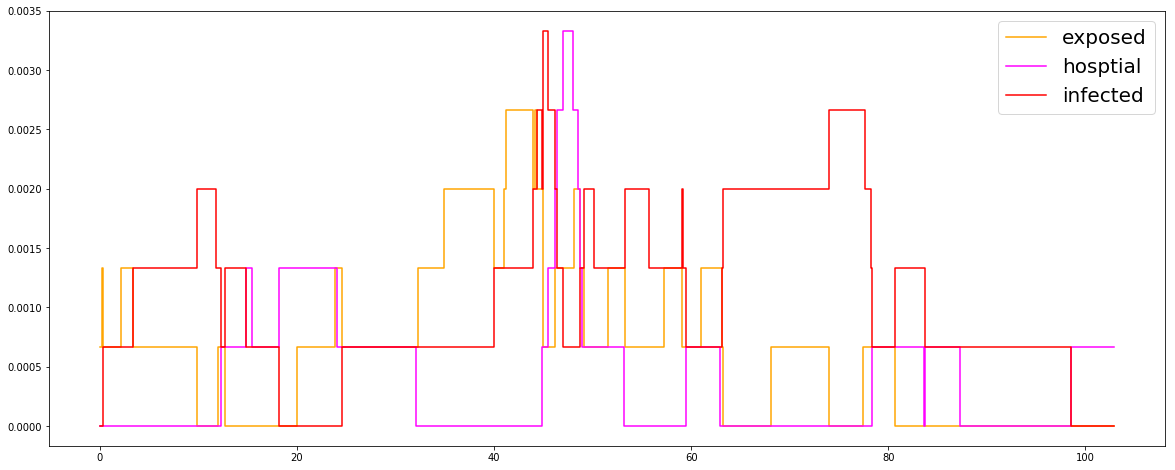

In [28]:
plt.figure(figsize = (20,8))
# plt.plot(SEIHRt, SEIHRr/Nn,c='blue', label = 'removed')
plt.plot(manht, manhe/Nn,c='orange', label = 'exposed')
plt.plot(manht, manhh/Nn,c='magenta', label = 'hosptial')

# plt.plot(SEIHRt,SEIHRs/Nn, c='yellowgreen',label = 'susceptible')
plt.plot(manht,manhi/Nn,c= 'r', label = 'infected')
plt.legend(fontsize = 20)

In [71]:
np.max(Gh[0])

113.46405012016712

In [330]:
β = 0.01
ϵ = 0.0001

## Multiple simulations

In [331]:
Time = []
Inf = []
Exp = []
Hos = []
Cum = []
Num_sim = 100
for i in range(Num_sim):
    Gh_adj = gillespieSEIHR(Input_H, β, μ1, μ2, σ, ω, ϵ, α,pp, γ, capT)
    SEIHRt_adj = Gh_adj[0]
    SEIHRs_adj = Gh_adj[1][:,0]
    SEIHRe_adj = Gh_adj[1][:,1]
    SEIHRi_adj = Gh_adj[1][:,2]
    SEIHRh_adj = Gh_adj[1][:,3]
    SEIHRr_adj = Gh_adj[1][:,4]
    manhe = []
    manht = []
    manhh = []
    manhi = []
    cum_inf = []
    for ind, x in enumerate(SEIHRt_adj):
        if ind<len(SEIHRt_adj)-1:
            manhe.append((SEIHRe_adj[ind], SEIHRe_adj[ind]))
            manhh.append((SEIHRh_adj[ind], SEIHRh_adj[ind]))
            manhi.append((SEIHRi_adj[ind], SEIHRi_adj[ind]))
            manht.append((SEIHRt_adj[ind], SEIHRt_adj[ind+1]))
            cum_inf.append((np.cumsum(np.array(Gh_adj[2]) == 1)[ind], np.cumsum(np.array(Gh_adj[2]) == 1)[ind])) 
    Time.append(np.array(manht).flatten())
    Inf.append(np.array(manhi).flatten())
    Exp.append(np.array(manhe).flatten())
    Hos.append(np.array(manhh).flatten())
    Cum.append(np.array(cum_inf).flatten())

In [332]:
i

99

In [333]:
max_time = []
num_inf = []
for k in range(i):
    max_time.append(max(Time[k]))
    num_inf.append(Cum[k][-1])
    
totalT = math.ceil(max(max_time))
inter_t = np.arange(0, totalT , 0.5)

In [334]:
np.mean(num_inf)

10.818181818181818

NameError: name 'max_time' is not defined

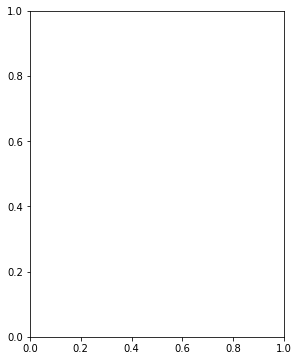

In [13]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(121)
bp = ax.boxplot(max_time, patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = 'teal' , alpha = 0.6)

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='grey', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='black', alpha = 0.3, linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='yellow', alpha=0.5)

plt.ylabel('Duration, days', fontsize =16)

ax = fig.add_subplot(122)
bp = ax.boxplot(num_inf, patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#00035b' , alpha = 0.6)

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='grey', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='black', alpha = 0.3, linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='yellow', alpha=0.5)

plt.ylabel('Final Size', fontsize = 16)

Text(0,0.5,'Duration')

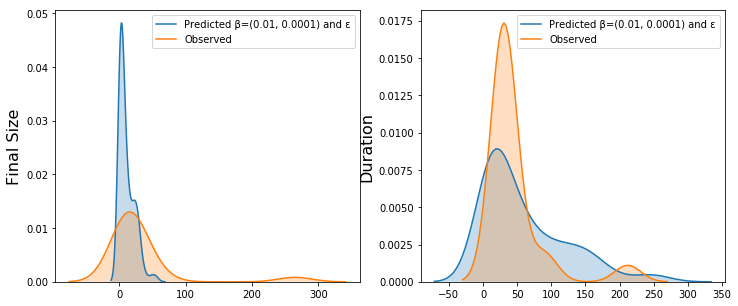

In [336]:
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
sns.kdeplot(num_inf, shade = True, label = 'Predicted β={} and ɛ'.format((β, ϵ)))
sns.kdeplot(Data['Total Cases'], shade = True, label = 'Observed')
plt.ylabel('Final Size', fontsize = 16)
plt.subplot(1,2,2)
sns.kdeplot(max_time, shade = True, label = 'Predicted β={} and ɛ'.format((β, ϵ)))
sns.kdeplot(Data['Duration'], shade = True, label = 'Observed')

plt.ylabel('Duration', fontsize =16)


In [337]:
# np.min(Data['Total Cases'].values)

/home/emma/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


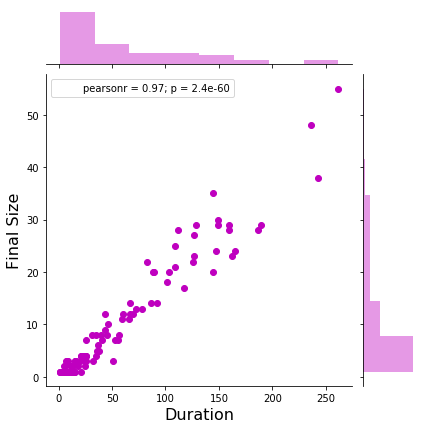

In [338]:
d= {'duration': max_time, 'finalsize': num_inf}
df = pd.DataFrame(data = d)
g = sns.jointplot(x="duration", y="finalsize", data=df[df['duration']<600], color = 'm')
# g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
# g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("Duration", "Final Size", fontsize = 16);

In [16]:
inter_i = []
inter_e = []
inter_h = []
inter_cum = []
for l in range(Num_sim):
    inter_i.append(np.interp(inter_t, Time[l], Inf[l], right = 0))
    inter_e.append(np.interp(inter_t, Time[l], Exp[l], right = 0))
    inter_h.append(np.interp(inter_t, Time[l], Hos[l], right = 0))
    inter_cum.append(np.interp(inter_t, Time[l], Cum[l]))

Text(0.5,1,'Cumulative Infections')

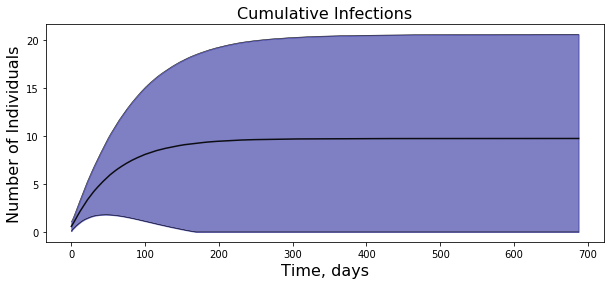

In [17]:
plt.figure(figsize = (10,4))
# plt.subplot(1,3,1)
plt.plot(inter_t, np.mean(inter_cum, axis = 0),'-', color ='k', alpha = 0.9)
plt.plot(inter_t, (np.mean(inter_cum, axis = 0)+np.std(inter_cum, axis = 0)), color ='k', lw=0.5)
plt.plot(inter_t, np.maximum((np.mean(inter_cum, axis = 0)-np.std(inter_cum, axis = 0)),0),color ='k', lw=0.5)
plt.fill_between(inter_t, (np.mean(inter_cum, axis = 0)+np.std(inter_cum, axis = 0)), np.maximum((np.mean(inter_cum, axis = 0)-np.std(inter_cum, axis = 0)),0), 1, alpha=0.5, color = 'darkblue')
# plt.ylim([0,20])
plt.ylabel('Number of Individuals', fontsize = 16)
plt.xlabel('Time, days', fontsize = 16)
plt.title('Cumulative Infections', fontsize = 16)

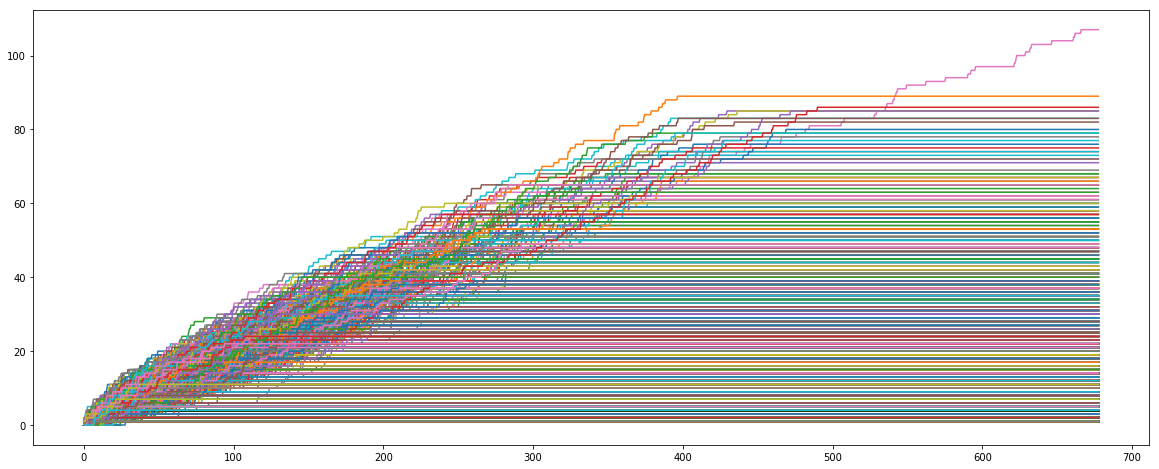

In [226]:
fig = plt.figure(figsize = (20,8))
for z in range(Num_sim):
    plt.plot(inter_t, inter_cum[z])
#     plt.subplot(1,3,1)
#     plt.plot(inter_t, inter_e[z]/Nn)
#     plt.title('Exposed')
#     plt.subplot(1,3,2)
#     plt.plot(inter_t, inter_i[z]/Nn)
#     plt.title('Infected')
#     plt.subplot(1,3,3)
#     plt.plot(inter_t, inter_h[z]/Nn)
#     plt.title('Hospitalized')

(0, 100)

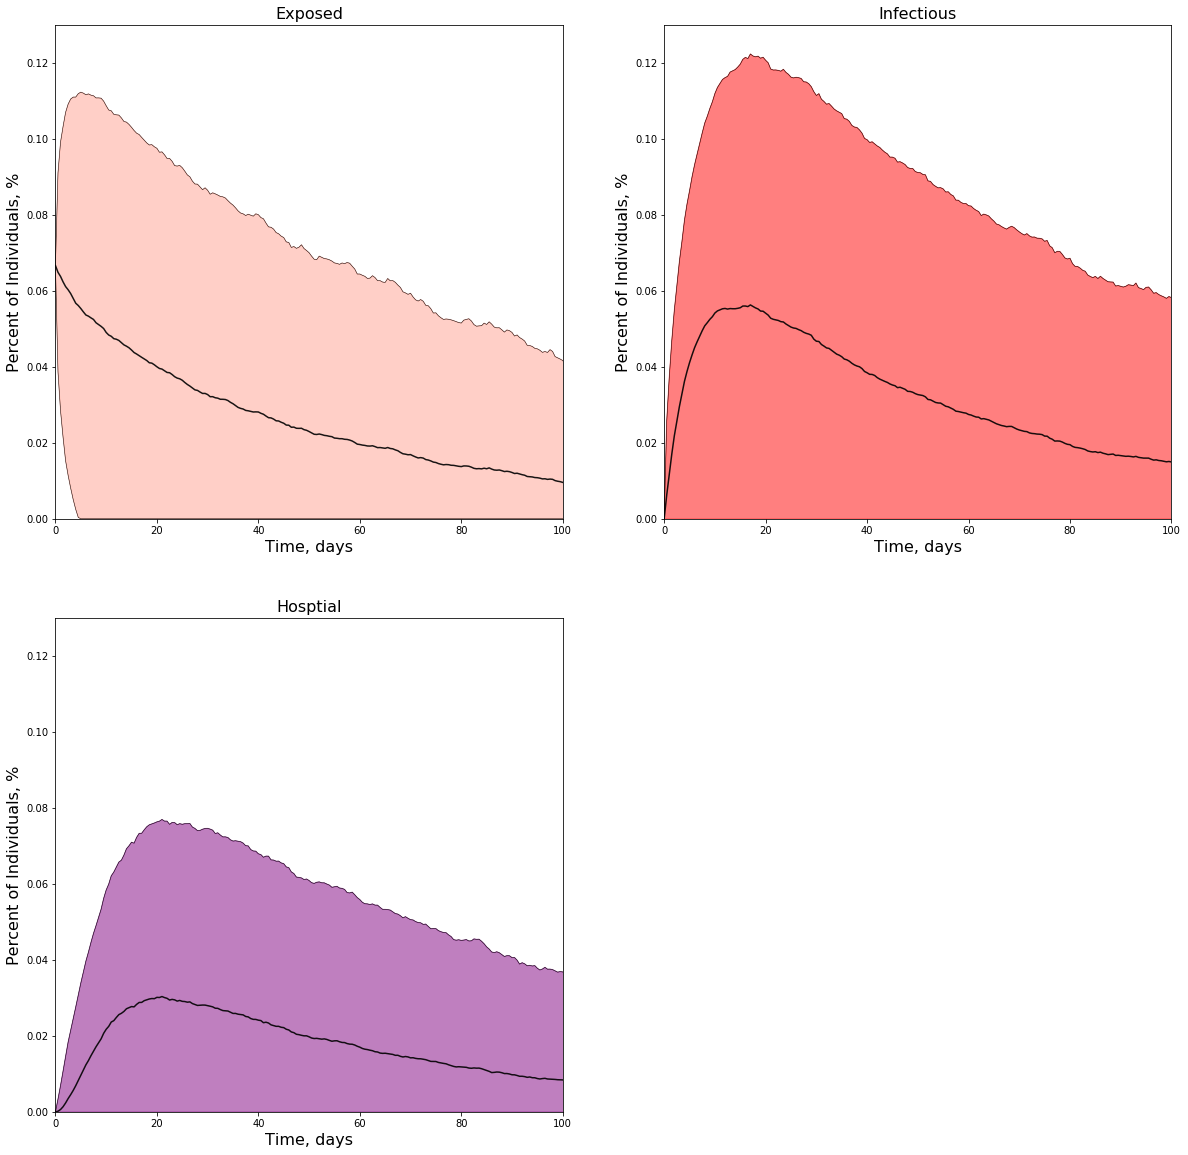

In [223]:
plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
plt.plot(inter_t, 100*np.mean(inter_e, axis = 0)/Nn,'-', color ='k', alpha = 0.9)
plt.plot(inter_t, 100*(np.mean(inter_e, axis = 0)+np.std(inter_e, axis = 0))/Nn, color ='k', lw=0.5)
# plt.plot(inter_t, 100*inter_e[5]/Nn, '--', color = 'grey')
plt.plot(inter_t, 100*np.maximum((np.mean(inter_e, axis = 0)-np.std(inter_e, axis = 0))/Nn,0),color ='k', lw=0.5)
plt.fill_between(inter_t,  100*(np.mean(inter_e, axis = 0)+np.std(inter_e, axis = 0))/Nn, 100*np.maximum((np.mean(inter_e, axis = 0)-np.std(inter_e, axis = 0))/Nn,0), 1, alpha=0.3, color = 'tomato')
plt.ylim([0,0.13])
plt.ylabel('Percent of Individuals, %', fontsize = 16)
plt.xlabel('Time, days', fontsize = 16)
plt.title('Exposed', fontsize = 16)
plt.xlim([0,100])

plt.subplot(2,2,2)
plt.plot(inter_t, 100*np.mean(inter_i, axis = 0)/Nn,'-', color ='k', alpha = 0.9)
plt.plot(inter_t, 100*(np.mean(inter_i, axis = 0)+np.std(inter_i, axis = 0))/Nn, color ='k', lw=0.5)
plt.plot(inter_t, 100*np.maximum((np.mean(inter_i, axis = 0)-np.std(inter_i, axis = 0))/Nn,0),color ='k', lw=0.5)
plt.fill_between(inter_t,  100*(np.mean(inter_i, axis = 0)+np.std(inter_i, axis = 0))/Nn, 100*np.maximum((np.mean(inter_i, axis = 0)-np.std(inter_i, axis = 0))/Nn,0), 1, alpha=0.5, color = 'red')
plt.ylim([0,0.13])
plt.ylabel('Percent of Individuals, %', fontsize = 16)
plt.xlabel('Time, days', fontsize = 16)
plt.title('Infectious', fontsize = 16)
plt.xlim([0,100])

plt.subplot(2,2,3)
plt.plot(inter_t, 100*np.mean(inter_h, axis = 0)/Nn,'-', color ='k', alpha = 0.9)
plt.plot(inter_t, 100*(np.mean(inter_h, axis = 0)+np.std(inter_h, axis = 0))/Nn, color ='k', lw=0.5)
plt.plot(inter_t, 100*np.maximum((np.mean(inter_h, axis = 0)-np.std(inter_h, axis = 0))/Nn,0),color ='k', lw=0.5)
plt.fill_between(inter_t,  100*(np.mean(inter_h, axis = 0)+np.std(inter_h, axis = 0))/Nn, 100*np.maximum((np.mean(inter_h, axis = 0)-np.std(inter_h, axis = 0))/Nn,0), 1, alpha=0.5, color = 'purple')
plt.ylim([0,0.13])
plt.ylabel('Percent of Individuals, %', fontsize = 16)
plt.xlabel('Time, days', fontsize = 16)
plt.title('Hosptial', fontsize = 16)
plt.xlim([0,100])


## Changing $\beta$ and $\varepsilon$

In [9]:
import time
# Num_param = 100
betas1 = np.linspace(0,0.01, 100)
eps1 = np.linspace(0,0.005, 100)
betas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
eps = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
Num_param = len(betas)
# Num_param

In [186]:
final = np.zeros(shape = (Num_param,Num_param))
duration = np.zeros(shape = (Num_param,Num_param))

for k in range(Num_param):
    for y in range(Num_param):
        start = time.time()
        B = betas[k]
        E = eps[y]
        Time = []
        Cum = []
        Num_sim = 100
        for i in range(Num_sim):
            Gh_adj = gillespieSEIHR(Input_H, B, μ1, μ2, σ, ω, E, α,pp, γ, capT)
            SEIHRt_adj = Gh_adj[0]
#             cum_inf = []
            manht = []
            for ind, x in enumerate(SEIHRt_adj):
                if ind<len(SEIHRt_adj)-1:
                    manht.append((SEIHRt_adj[ind], SEIHRt_adj[ind+1]))
#                     cum_inf.append((np.cumsum(np.array(Gh_adj[2]) == 1)[ind], np.cumsum(np.array(Gh_adj[2]) == 1)[ind])) 
            Time.append(np.array(manht).flatten())
            Cum.append(sum(np.array(Gh_adj[2])==1))
#             Cum.append(np.array(cum_inf).flatten())
        total_time = []
#         num_inf = []
        for j in range(Num_sim):
            total_time.append(max(Time[j]))
#             num_inf.append(np)
#         print(np.mean(Cum))
        final[k,y] = np.mean(Cum)
        duration[k,y] = np.mean(total_time)
#         print("k,y, time ", k,y, time.time() - start)

In [307]:
duration[4,3]
# betas[2]

560.2319699084222

In [88]:
# np.savetxt('final_size.txt', final, fmt='%d')
# np.savetxt('duration.txt', duration, fmt='%d')
np.savetxt('order_final_size.txt', final, fmt='%d')
np.savetxt('order_duration.txt', duration, fmt='%d')

In [6]:
b = np.loadtxt('order_final_size.txt')
a = np.loadtxt('order_duration.txt')
# duration
# len(betas1)

In [8]:
# final = np.array(final)
# final.shape
# duration = np.array(duration)
# eps

In [299]:
eps = np.flip(eps, 0)

Text(51,0.5,'β')

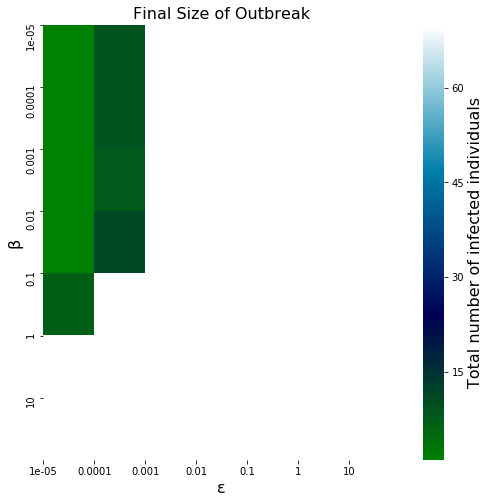

In [18]:
# sns.heatmap(final, cmap='terrain')
fig, ax = plt.subplots(figsize=(8,8))
# plt.subplot(1,1,1)
pcm = sns.heatmap(b,  cmap= 'ocean', vmax = 70, cbar_kws={'label': 'Total number of infected individuals'}) # you don't need rasterized=True
# fig.colorbar(pcm)
pcm.figure.axes[-1].yaxis.label.set_size(16)

plt.title('Final Size of Outbreak', fontsize = 16)
plt.xticks(np.arange(7),betas)
plt.yticks(np.arange(7), eps)
plt.xlabel('ɛ', fontsize = 16)
plt.ylabel('β', fontsize = 16)

# plt.subplot(1,2,2)
# pcm = sns.heatmap( a, cmap= 'ocean', vmin = 0, vmax = 100,  cbar_kws={'label': 'Total number of days'}) # you don't need rasterized=True
# # fig.colorbar(pcm)
# pcm.figure.axes[-1].yaxis.label.set_size(16)
# plt.title('Duration of Outbreak', fontsize = 16)

# plt.xlabel('ɛ', fontsize = 16)
# plt.ylabel('β', fontsize = 16)
# plt.xticks(np.arange(7),betas)
# plt.yticks(np.arange(7), eps)
# normi = plt.colors.Normalize(vmin=0, vmax=200);
# # plt.show()

In [189]:
X = []
betas2 = np.linspace(0,0.01, Num_param)
eps2 = np.linspace(0,0.005, Num_param)
Y = []
Z = []
Z2 = []
for i in range(len(betas)):
    for j in range(len(eps)):
        X.append(betas[i])
        Y.append(eps[j])
        Z.append(final[i,j])
        Z2.append(duration[i,j])
Z = np.array(Z)
Z2 = np.array(Z2)

In [190]:
# from mpl_toolkits.basemap import Basemap
# from mpl_toolkits.natgrid import _natgrid
eps

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]

In [191]:

ax = fig.gca(projection='3d')
# xi =range(7)
# yi = range(7)
xi = np.linspace(min(X), max(X))
yi = np.linspace(min(Y), max(Y))

xx, yy = np.meshgrid(xi, yi)
zz = griddata(X, Y, Z, xi, yi,interp='linear')
z2 = griddata(X, Y, Z2, xi, yi,interp='linear')
surf = ax.plot_surface(xi, yi, zz, rstride=5, cstride=5, cmap=cm.jet,
                       linewidth=1, antialiased=True)
surf2 = ax.plot_surface(xx, yy, z2, rstride=5, cstride=5, cmap=cm.jet,
                       linewidth=1, antialiased=True)
# ax.set_zlim3d(np.min(Z), np.max(Z))
# fig.colorbar(surf)

# plt.show()

/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  
/home/emma/.local/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2.
  if __name__ == '__main__':
/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2.


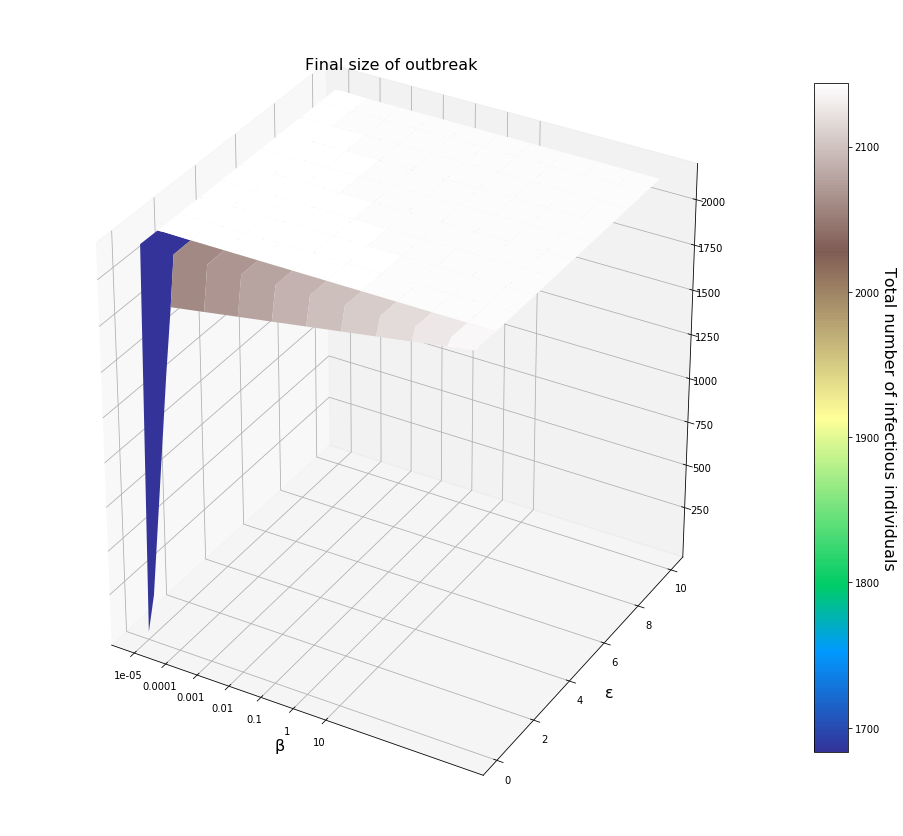

In [196]:

%matplotlib inline
fig = plt.figure(figsize =(15,15))
ax = fig.gca(projection='3d')
# plt.subplot(1,2,1)
surf = ax.plot_surface(xx, yy, zz, rstride=5, cstride=5, cmap=cm.terrain,
                       linewidth=1, antialiased=True)
ax.set_zlim3d(np.min(Z), np.max(Z))
# fig.colorbar(surf)
cbar = fig.colorbar(surf,fraction=0.04)
cbar.ax.get_yaxis().labelpad = 16
cbar.ax.set_ylabel('Total number of infectious individuals', rotation=270, fontsize = 16)
plt.xlabel('β', fontsize = 16)
plt.ylabel('ɛ', fontsize = 16)
plt.xticks(range(7),betas)
# plt.yticks(range(7), eps)
plt.title('Final size of outbreak', fontsize = 16)
plt.show()

In [193]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

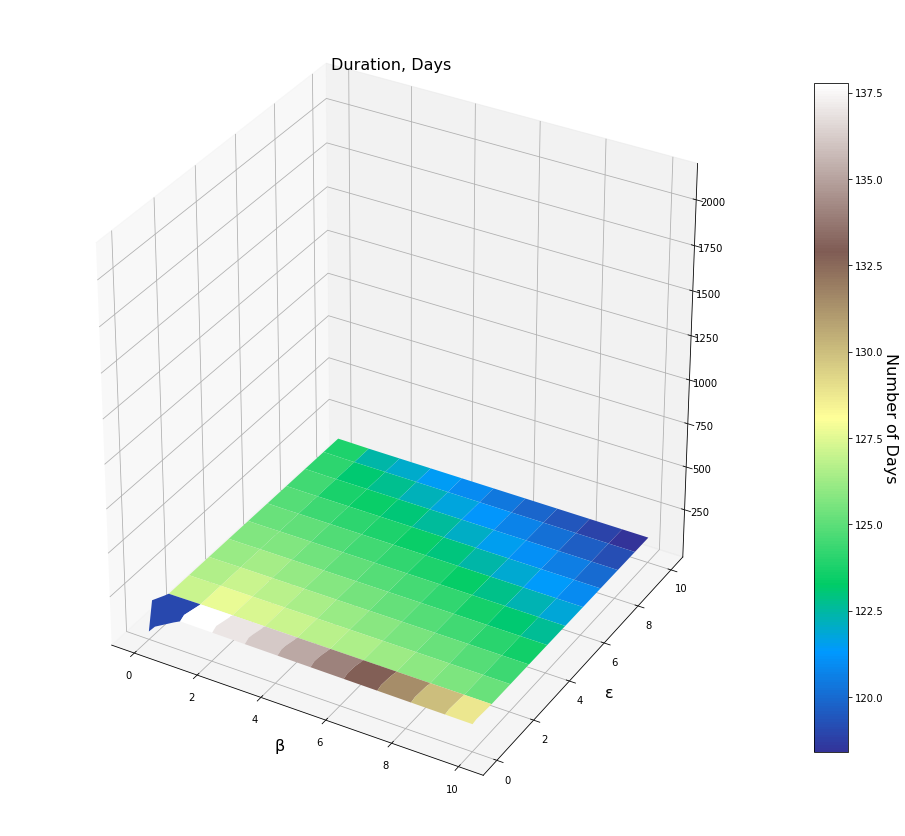

In [194]:
%matplotlib inline
fig = plt.figure(figsize =(15,15))
ax = fig.gca(projection='3d')
# plt.subplot(1,2,1)
surf = ax.plot_surface(xx, yy, z2, rstride=5, cstride=5, cmap=cm.terrain,
                       linewidth=1, antialiased=True)
ax.set_zlim3d(np.min(Z2), np.max(Z2))
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(surf,fraction=0.04)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Number of Days', rotation=270, fontsize = 16)
# cbar.set_label('Number of Days', rotation=270, fontsize = 16)
plt.xlabel('β', fontsize = 16)
plt.ylabel('ɛ', fontsize = 16)
plt.title('Duration, Days', fontsize = 16)
plt.show()

# Switching external environment ($\varepsilon$)

In [32]:
β = 0.005
μ1 = 1/10 #14 days infectious
μ2 = 1/5 #5 days (14 - 9 days)
σ =1/5 #5 days exposed
ω=1/9 # 9 days until emitted to hospital
ϵ = 0.0001
α = 1/2
pp = 0.7
capT = 10000
γ = 1/(80*365)
Input_H = [1500,1,0,0,0]

In [81]:
def gillespieSEIR_season(initial, beta, mu1,mu2, sigma, omega,epsilon,alpha, mort, gam,  max_time):
    event_time = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    event_time.append(0)
    times = 0
    ind = 0
    year = 1
    cuminf = []
    cuminf.append(0)
    events = []
    while times <max_time:
        state = np.zeros(shape= (4,12))
        
        ############################### Seasonality #######################################
        if np.round(times)%365 <= 120:
            E = epsilon
        else:
            E = 0
#         print(E)
        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################    
        
        
        R_se = beta*(pop[ind][0])*(pop[ind][2])/N + E*pop[ind][0] 
        state[:,0] = [-1, 1, 0, 0]
        
        R_ei = sigma*pop[ind][1]
        state[:,1] = [0, -1, 1, 0]
        

        
        R_ir = mu2*pop[ind][2]
        state[:,2] = [0,0,-1,1]
        

        R_is = mu1*pop[ind][2]
        state[:,3] = [1,0,-1,0]
        
        R_sb = sum(initial[:3])*gam
        state[:,4] = [1, 0, 0, 0]
        
        R_sd = gam*pop[ind][0]
        state[:,5] = [-1, 0, 0, 0]
        
        R_ed = gam*pop[ind][1]
        state[:,6] = [0,-1,0,0]
        
        R_id = gam*pop[ind][2]
        state[:,7] = [0, 0, -1, 0]
        
#         R_rd = gam*pop[ind][3]
#         state[:,8] = [0, 0, 0, -1]
########################## RATES ##############################
        rate = [R_se, R_ei,  R_ir,  R_is, R_sb, R_sd, R_ed, R_id]

        Rtotal = sum(rate)
#         print('Rtotal, E', pop[ind][1]+pop[ind][2]+pop[ind][3], rate, Rtotal, E)

#         delta_t = np.random.exponential(Rtotal)
        delta_t= -np.log(np.random.uniform(0,1))/Rtotal
        P = np.random.uniform(0,1)*Rtotal
        
        if Rtotal>0:
            times =times+ delta_t
            event = np.min(np.where(P<=np.cumsum(rate)))
            events.append(event)
            event_time.append(times)
            pop.append(pop[ind]+state[:,event])
        else:
#             print(year, times)
            times = year*365
#             print(year, times)

            year = year +1 
            events.append(-1)
            event_time.append(times)
            pop.append(pop[ind])
        if event == 1:
            cuminf.append(1 +cuminf[ind] )
        else:
            cuminf.append(0 +cuminf[ind])
        ind=ind+1
        N = sum(pop[ind][:5])

    return event_time, np.array(pop), events

In [87]:
def gillespieSEIHR_season(initial, beta, mu1,mu2, sigma, omega,epsilon,alpha, mort, gam,  max_time):
    event_time = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    event_time.append(0)
    times = 0
    ind = 0
    year = 1
    cuminf = []
    cuminf.append(0)
    events = []
    while times <max_time:
        state = np.zeros(shape= (5,12))
        
        ############################### Seasonality #######################################
        if np.round(times)%365 <= 120:
            E = epsilon
        else:
            E = 0
#         print(E)
        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################    
        
        
        R_se = beta*(pop[ind][0])*(pop[ind][2] + alpha*pop[ind][3])/N + E*pop[ind][0] 
        state[:,0] = [-1, 1, 0, 0,0]
        
        R_ei = sigma*pop[ind][1]
        state[:,1] = [0, -1, 1, 0,0]
        
        R_ih = omega*pop[ind][2]
        state[:,2] = [0, 0, -1, 1, 0]
        
        R_ir = mort*mu1*pop[ind][2]
        state[:,3] = [0,0,-1,0,1]
        
        R_hr = mort*mu2*pop[ind][3]
        state[:,4] = [0,0,0,-1,1]

        R_is = (1-mort)*mu1*pop[ind][2]
        state[:,5] = [1,0,-1,0,0]
        
        R_hs = (1-mort)*mu2*pop[ind][3]
        state[:,6] = [1,0,0,-1,0]
        
########################## RATES ##############################
        rate = [R_se, R_ei, R_ih, R_ir, R_hr, R_is, R_hs]

        Rtotal = sum(rate)
#         print('Rtotal, E', pop[ind][1]+pop[ind][2]+pop[ind][3], rate, Rtotal, E)

#         delta_t = np.random.exponential(Rtotal)
        delta_t= -np.log(np.random.uniform(0,1))/Rtotal
        P = np.random.uniform(0,1)*Rtotal
        
        if Rtotal>0:
            times =times+ delta_t
            event = np.min(np.where(P<=np.cumsum(rate)))
            events.append(event)
            event_time.append(times)
            pop.append(pop[ind]+state[:,event])
        else:
#             print(year, times)
            times = year*365
#             print(year, times)

            year = year +1 
            events.append(-1)
            event_time.append(times)
            pop.append(pop[ind])
        if event == 1:
            cuminf.append(1 )
        else:
            cuminf.append(0)
        ind=ind+1
        N = sum(pop[ind][:5])

    return event_time, np.array(pop), events

In [88]:
Input_H = [1500, 1, 0, 0]
Gh_season = gillespieSEIR_season(Input_H, β, μ1, μ2, σ, ω, ϵ, α,pp, γ, capT)
SEIHRt_s = Gh_season[0]
SEIHRs_s = Gh_season[1][:,0]
SEIHRe_s = Gh_season[1][:,1]
SEIHRi_s = Gh_season[1][:,2]
# SEIHRh_s = Gh_season[1][:,3]
SEIHRr_s = Gh_season[1][:,3]

In [89]:
manhes = []
manhts = []
manhhs = []
manhis = []
manhss = []
manhrs = []
for ind, x in enumerate(SEIHRt_s):
    if ind<len(SEIHRt_s)-1:
        manhes.append((SEIHRe_s[ind], SEIHRe_s[ind]))
#         manhhs.append((SEIHRh_s[ind], SEIHRh_s[ind]))
        manhis.append((SEIHRi_s[ind], SEIHRi_s[ind]))
        manhss.append((SEIHRs_s[ind], SEIHRs_s[ind]))
        manhrs.append((SEIHRr_s[ind], SEIHRr_s[ind]))
        manhts.append((SEIHRt_s[ind], SEIHRt_s[ind+1]))
manhes = np.array(manhes).flatten()
manhts = np.array(manhts).flatten()
manhss = np.array(manhss).flatten()
manhrs = np.array(manhrs).flatten()
# manhhs = np.array(manhhs).flatten()
manhis = np.array(manhis).flatten()

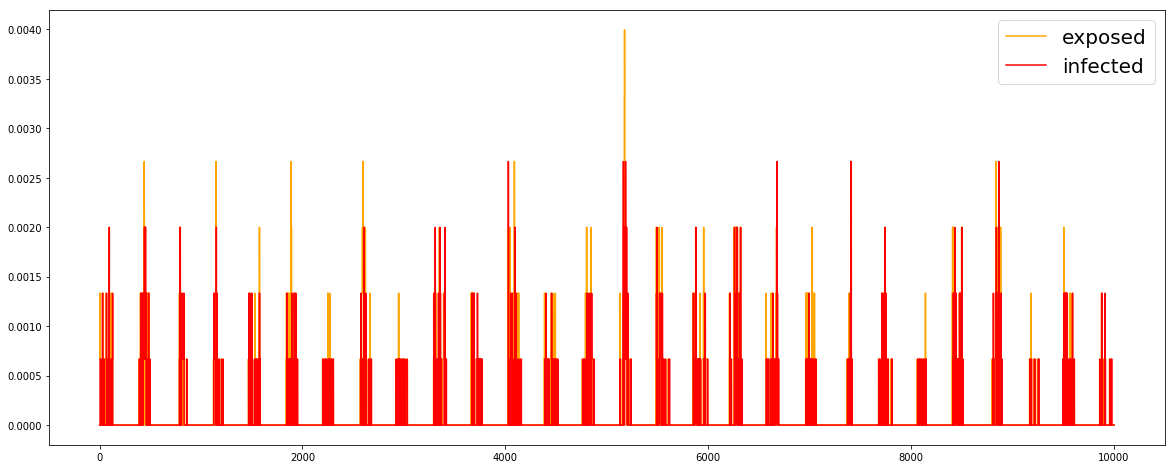

In [90]:
plt.figure(figsize = (20,8))
# plt.plot(SEIHRt, SEIHRr/Nn,c='blue', label = 'removed')
plt.plot(manhts, manhes/Nn,c='orange', label = 'exposed')
# plt.plot(manhts, manhhs/Nn,c='magenta', label = 'hospital')

# plt.plot(manhts,manhrs/Nn, c='yellowgreen',label = 'susceptible')
plt.plot(manhts,manhis/Nn,c= 'r', label = 'infected')
plt.legend(fontsize = 20)
# plt.xlim([0,300])

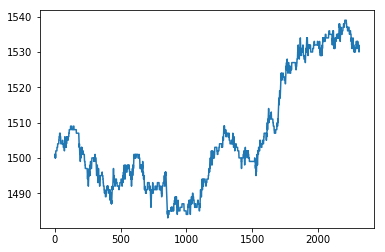

In [91]:
plt.plot(range(len(np.sum(Gh_season[1], axis = 1))), np.sum(Gh_season[1], axis = 1))

In [92]:
[0,1,2,3][:3]

[0, 1, 2]

### SEIHR --- variation in parameters

In [11]:
β = 0.005
ϵ = 0.0001
α = 1/2
capT = 10000
Input_H = [1500,1,0,0,0]

# μ1 = 1/np.mean(np.random.gamma(25, 0.765,1000)) #mean 19 days 
# μ2 = 1/np.mean(np.random.gamma(6, 0.8,1000)) #5 days (14 - 9 days)
# σ =1/np.mean(np.random.gamma(5,1,1000)) #5 days exposed
# ω=1/np.mean(np.random.gamma(15, 0.6,1000)) # 9 days until emitted to hospital
# ϵ = 0.0001
# α = 1/2
# pp = np.mean(np.random.beta(7,3,1000))


In [13]:
def gillespieSEIHR_adj(initial, beta, epsilon,alpha,  max_time):
    event_time = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    event_time.append(0)
    times = 0
    ind = 0
    cuminf = []
    cuminf.append(0)
    events = []
    while times <max_time and (pop[ind][1]+pop[ind][2]+pop[ind][3]>0):
        state = np.zeros(shape= (5,12))
        
        mu1 = 1/np.random.gamma(25, 0.765)
        mu2 = 1/np.random.gamma(6, 0.8)
        sigma = 1/np.random.gamma(5,1)
        omega = 1/np.random.gamma(15, 0.6)
        mort = np.random.beta(7,3)
        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################
        
        
        R_se = beta*(pop[ind][0])*(pop[ind][2] + alpha*pop[ind][3])/N + epsilon*pop[ind][0] 
        state[:,0] = [-1, 1, 0, 0,0]
        
        R_ei = sigma*pop[ind][1]
        state[:,1] = [0, -1, 1, 0,0]
        
        R_ih = omega*pop[ind][2]
        state[:,2] = [0, 0, -1, 1, 0]
        
        R_ir = mort*mu1*pop[ind][2]
        state[:,3] = [0,0,-1,0,1]
        
        R_hr = mort*mu2*pop[ind][3]
        state[:,4] = [0,0,0,-1,1]

        R_is = (1-mort)*mu1*pop[ind][2]
        state[:,5] = [1,0,-1,0,0]

        R_hs = (1-mort)*mu2*pop[ind][3]
        state[:,6] = [1,0,0,-1,0]
#         print(1/mu1, 1/mu2, 1/sigma, 1/omega, mort)

        rate = [R_se, R_ei, R_ih, R_ir, R_hr, R_is, R_hs]

        Rtotal = sum(rate)
        delta_t= -np.log(np.random.uniform(0,1))/Rtotal

        P = np.random.uniform(0,1)*Rtotal
        times =times+ delta_t
        event = np.min(np.where(P<=np.cumsum(rate)))
        events.append(event)
        event_time.append(times)
        pop.append(pop[ind]+state[:,event])
        
        if event == 1:
            cuminf.append(1 )
        else:
            cuminf.append(0)
        ind=ind+1
        N = sum(pop[ind][:5])

    return event_time, np.array(pop), events

In [14]:
def dSEIHR_dt(X, tt ):
#     print(sum(X[:3]))
    return [-β*X[0]*(X[2]+α*X[3])/sum(X[:3]) - ϵ*X[0] + (1-pp)*(μ1*X[2] + μ2*X[3]), 
            β*X[0]*(X[2]+α*X[3])/sum(X[:3]) + ϵ*X[0]- σ*X[1] ,
            σ*X[1] - (μ1+ω)*X[2],
            ω*X[2]-μ2*X[3],
            pp*(μ1*X[2]+μ2*X[3])]

ts = np.linspace(0, capT, 1000)
Nn = sum(Input_H)
P_seihr = odeint(dSEIHR_dt, Input_H, ts)

In [63]:
Gh_adj = gillespieSEIHR_adj(Input_H, β, ϵ, α, capT)
SEIHRt_adj = Gh_adj[0]
SEIHRs_adj = Gh_adj[1][:,0]
SEIHRe_adj = Gh_adj[1][:,1]
SEIHRi_adj = Gh_adj[1][:,2]
SEIHRh_adj = Gh_adj[1][:,3]
SEIHRr_adj = Gh_adj[1][:,4]

In [64]:
# manhe = [SEIHRe_adj[0]]
# manht = [SEIHRt_adj[0]]
# manhh = [SEIHRh_adj[0]]
# manhi = [SEIHRi_adj[0]]
manhe = []
manht = []
manhh = []
manhi = []
for ind, x in enumerate(SEIHRt_adj):
    if ind<len(SEIHRt_adj)-1:
        manhe.append((SEIHRe_adj[ind], SEIHRe_adj[ind]))
        manhh.append((SEIHRh_adj[ind], SEIHRh_adj[ind]))
        manhi.append((SEIHRi_adj[ind], SEIHRi_adj[ind]))
        manht.append((SEIHRt_adj[ind], SEIHRt_adj[ind+1]))

In [66]:
manhe = np.array(manhe).flatten()
manht = np.array(manht).flatten()
manhh = np.array(manhh).flatten()
manhi = np.array(manhi).flatten()

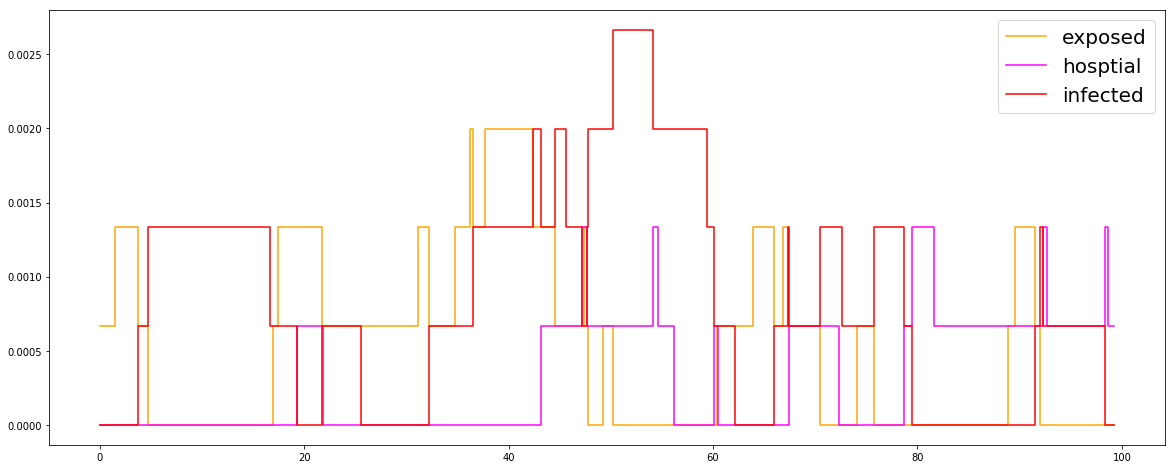

In [67]:
plt.figure(figsize = (20,8))
# plt.plot(SEIHRt, SEIHRr/Nn,c='blue', label = 'removed')
plt.plot(manht, manhe/Nn,c='orange', label = 'exposed')
plt.plot(manht, manhh/Nn,c='magenta', label = 'hosptial')

# plt.plot(SEIHRt,SEIHRs/Nn, c='yellowgreen',label = 'susceptible')
plt.plot(manht,manhi/Nn,c= 'r', label = 'infected')
plt.legend(fontsize = 20)


array([ 0.        ,  1.51677169,  1.51677169,  2.54554497,  2.54554497,
        3.69159289,  3.69159289,  4.71755647,  4.71755647,  7.53175824,
        7.53175824,  8.65357837,  8.65357837, 13.47787775])

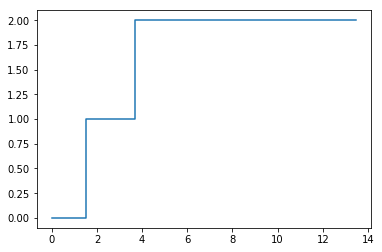

In [149]:
total_inf = []
cum_t = []
for ind, x in enumerate(SEIHRt_adj):
    if ind<len(SEIHRt_adj)-1:
        cum_t.append((SEIHRt_adj[ind], SEIHRt_adj[ind+1]))
        total_inf.append((np.cumsum(np.array(Gh_adj[2]) == 1)[ind], np.cumsum(np.array(Gh_adj[2]) == 1)[ind])) 
# np.cumsum(np.array(Gh_adj[2]) == 1)
plt.plot(np.array(cum_t).flatten(), np.array(total_inf).flatten())
total_inf
np.array(cum_t).flatten()

In [3]:
Time = []
Inf = []
Exp = []
Hos = []
N = 100
for i in range(N):
    Gh_adj = gillespieSEIHR_adj(Input_H, β, ϵ, α, capT)
    SEIHRt_adj = Gh_adj[0]
    SEIHRs_adj = Gh_adj[1][:,0]
    SEIHRe_adj = Gh_adj[1][:,1]
    SEIHRi_adj = Gh_adj[1][:,2]
    SEIHRh_adj = Gh_adj[1][:,3]
    SEIHRr_adj = Gh_adj[1][:,4]
    manhe = []
    manht = []
    manhh = []
    manhi = []
    for ind, x in enumerate(SEIHRt_adj):
        if ind<len(SEIHRt_adj)-1:
            manhe.append((SEIHRe_adj[ind], SEIHRe_adj[ind]))
            manhh.append((SEIHRh_adj[ind], SEIHRh_adj[ind]))
            manhi.append((SEIHRi_adj[ind], SEIHRi_adj[ind]))
            manht.append((SEIHRt_adj[ind], SEIHRt_adj[ind+1]))
    Time.append(manht)
    Inf.append(manhi)
    Exp.append(manhe)
    Hos.append(manhh)

NameError: name 'gillespieSEIHR_adj' is not defined